In [7]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
image_dir = 'cavallo'

images = []
for filename in os.listdir(image_dir):
    image_path = os.path.join(image_dir, filename)
    image = cv2.imread(image_path)

    if image is not None:
        image = cv2.resize(image, (120, 120))
        images.append(image)

print("Number of images read:", len(images))

Number of images read: 2623


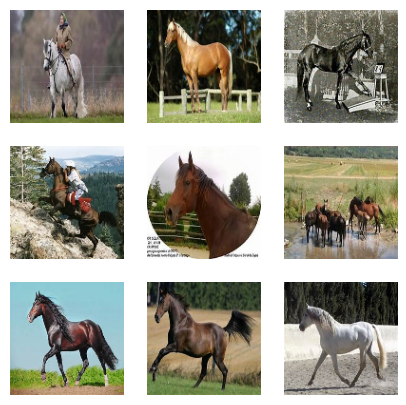

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.show()

In [10]:
def divide_image(image):
    parts = []
    height, width, _ = image.shape
    part_height = height // 3
    part_width = width // 3
    
    for i in range(3):
        for j in range(3):
            part = image[i*part_height:(i+1)*part_height, j*part_width:(j+1)*part_width]
            parts.append(part)
    
    return parts

In [11]:
def generate_combinations(parts, num_combinations):
    combinations = []
    original_positions = []
    indices = list(range(len(parts)))
    
    for _ in range(num_combinations):
        random.shuffle(indices)
        combination = [parts[i] for i in indices]
        combinations.append(combination)
        original_positions.append(indices.copy())
    
    return combinations, original_positions

In [12]:
def stitch_shuffled_image(parts):
    num_parts = len(parts)
    part_size = parts[0].shape[0]  # Assuming all parts are square
    
    stitched_image_size = int(np.sqrt(num_parts) * part_size)
    stitched_image = np.zeros((stitched_image_size, stitched_image_size, parts[0].shape[2]), dtype=np.uint8)
    
    for i in range(stitched_image.shape[0] // part_size):
        for j in range(stitched_image.shape[1] // part_size):
            part_index = i * int(stitched_image.shape[0] / part_size) + j
            stitched_image[i*part_size:(i+1)*part_size, j*part_size:(j+1)*part_size] = parts[part_index]
    
    return stitched_image

In [13]:
input_data = []
target_data = []
non_converted_target_data = []

for image in images:
    parts = divide_image(image)
    combinations, original_positions = generate_combinations(parts, 10)
    
    for idx, combination in enumerate(combinations):

        # shape of combination is (9, 40, 40, 3)
        combination = np.array(combination).transpose(0, 3, 1, 2)
        combination = np.concatenate(combination, axis=0).transpose(1, 2, 0)
        input_data.append(combination)

        dummy_target = np.zeros((9, 9), dtype=np.uint8)
        for i in range(9):
            dummy_target[i, original_positions[idx][i]] = 1

        target_data.append(dummy_target.flatten())
        non_converted_target_data.append(original_positions[idx])

In [14]:
input_data = np.array(input_data)
target_data = np.array(target_data)

print("Input data shape:", input_data.shape)
print("Target data shape:", target_data.shape)

Input data shape: (26230, 40, 40, 27)
Target data shape: (26230, 81)


In [16]:
# select random image
idx = random.randint(0, len(input_data))
print("target", target_data[idx].reshape(9, 9), sep="\n")
print("non_converted_target", non_converted_target_data[idx])

target
[[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]]
non_converted_target [3, 4, 0, 1, 2, 8, 5, 6, 7]


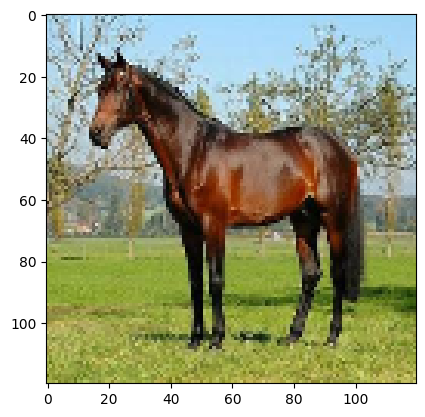

In [17]:
# checking if the target sequence is correct
# checking if the target sequence is correct
def reconstructed_image(img, non_converted_target_data, test=False):
    
    sequenced = [0] * 9
    for i in range(0,27,3):

        # stack the 3 channels to get the original image
        blue_channel = img[:,:,i]
        green_channel = img[:,:,i+1]
        red_channel = img[:,:,i+2]

        # stack the 3 channels to get the original image
        tile = np.stack((blue_channel, green_channel, red_channel), axis=2)

        if test:
            sequenced[i // 3] = tile
        else:
            sequenced[non_converted_target_data[i // 3]] = tile

    stiched_img = stitch_shuffled_image(sequenced)
    return stiched_img


reconstructed_img = reconstructed_image(input_data[idx], non_converted_target_data[idx])
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))

In [19]:
class JigsawDataset(Dataset):
    def __init__(self, input_data, target_data, transform=None):
        self.input_data = input_data
        self.target_data = target_data
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        image = self.input_data[idx]
        target = self.target_data[idx]

        if self.transform:
            image = self.transform(image)

        return image, target

In [20]:
X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.2, random_state=42)

train_dataset = JigsawDataset(X_train, y_train)
test_dataset = JigsawDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [ ]:

from transformers import CLIPProcessor, CLIPModel


import torch.optim as optim


num_epochs = 10
batch_size = 64


model_name = 'openai/clip-vit-base-patch32'
clip_model = CLIPModel.from_pretrained(model_name)
clip_processor = CLIPProcessor.from_pretrained(model_name)
vision_model = clip_model.vision_model


# num_labels = 81

# extended_model = ExtendedCLIPModel(clip_model, vision_feature_dim, num_labels)
# optimizer = AdamW(extended_model.parameters(), lr=5e-5)
# loss_fn = nn.BCEWithLogitsLoss()

# num_epochs = 1

# extended_model.train()
# for epoch in range(num_epochs):
#     for batch in train_loader:
#         inputs = clip_processor(images=batch[0], return_tensors='pt')

#         outputs = extended_model(inputs['pixel_values'])

#         loss = loss_fn(outputs, batch[1].float())

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         print(f"Epoch {epoch}, Loss: {loss.item()}")

# torch.save(extended_model.state_dict(), 'fine_tuned_clip_model.pth')


In [32]:
input_data[:1].shape 

(1, 40, 40, 27)

In [30]:
from transformers import CLIPProcessor, CLIPModel


# Load the model and processor
model_name = 'openai/clip-vit-base-patch32'
clip_model = CLIPModel.from_pretrained(model_name)
clip_processor = CLIPProcessor.from_pretrained(model_name)
clip_model.eval()

(1, 40, 40, 27)

In [35]:
from PIL import Image


# Assuming 'single_image' is your numpy array of shape (1, 40, 40, 27)
single_image = input_data[:1] # Example data

# Number of channels to step through each iteration (3 channels at a time)
channel_step = 3
total_channels = 27

feature_list = []

# Iterate through each triplet of channels
for start_channel in range(0, total_channels, channel_step):
    end_channel = start_channel + channel_step

    # Select the current set of three channels
    rgb_image = single_image[:, :, :, start_channel:end_channel]

    # Convert numpy array to PIL Image
    # Note: Squeeze to remove the single batch dimension and multiply by 255 for correct color scaling
    rgb_image_pil = Image.fromarray((rgb_image.squeeze() * 255).astype('uint8'), 'RGB')

    # Process image through CLIP
    inputs = clip_processor(images=rgb_image_pil, return_tensors='pt')

    with torch.no_grad():
        # Get image features from CLIP
        outputs = clip_model.get_image_features(**inputs)

    # Outputs can be processed or stored as required
    print(f"Features for channels {start_channel+1} to {end_channel}:")
    print(outputs)

    feature_list.append(outputs)

# Outputs will contain the image features for each set of channels


Features for channels 1 to 3:
tensor([[ 9.6823e-02, -1.2308e-01, -3.4584e-01, -2.9249e-01, -7.5497e-02,
         -1.4547e-01,  2.3592e-02,  1.2259e+00,  2.8427e-01,  2.4031e-01,
          3.2128e-01,  3.6343e-02,  3.4673e-01, -1.5545e-01, -2.9713e-01,
          7.0361e-02, -2.1833e-01,  1.4486e-01,  1.4458e-01,  5.8284e-02,
          3.4374e-01, -4.4289e-03, -1.9600e-01, -2.8608e-01, -1.7717e-02,
          5.5851e-02,  9.8034e-02, -1.8523e-01,  3.3794e-03,  1.8568e-01,
          1.8603e-01, -1.5203e-01,  1.4966e-01, -6.8051e-02, -8.0884e-01,
          7.4522e-02, -2.5721e-01,  2.3149e-01, -3.3210e-01,  1.1349e-02,
         -3.7374e-02, -1.6714e-01, -1.0857e-01,  1.7431e-01, -8.9825e-02,
          1.6866e+00,  1.6032e-01, -3.7637e-02, -7.1545e-02, -5.5480e-02,
          1.8637e-01,  1.5301e-01,  2.4727e-01, -9.2491e-03,  3.1405e-01,
         -1.1445e-01, -1.6187e-01,  1.8903e-01, -8.5346e-02, -3.0139e-01,
          3.7864e-01, -3.1443e-01, -3.7166e-02, -3.6958e-01,  1.4996e-03,
        